In [59]:
import os
from dotenv import load_dotenv

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [60]:
from typing import Annotated, Dict, List, TypedDict, Any, Optional
from langchain.document_loaders import PyPDFLoader  # PDF 파일 로더 사용
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
from langchain_openai import OpenAIEmbeddings
from kiwipiepy import Kiwi

pdf_file = "osang.pdf"

# 1) PDF 문서 로드
loader = PyPDFLoader(pdf_file)
pdf_docs = loader.load()

# 2) 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50,
)
pdf_doc_splits = text_splitter.split_documents(pdf_docs)
print(f"PDF에서 Chunk: {len(pdf_doc_splits)}")

PDF에서 Chunk: 203


In [61]:
import pandas as pd
from langchain.schema import Document

# CSV 파일의 처음 1000행만 로드 (테스트용)
df = pd.read_csv("company_data.csv", nrows=1000)

def row_to_text(row) -> str:
    template = (
        f"회사명: {row['company']}\n"
        f"주소: {row['address']}\n"
        f"홈페이지: {row['homepage']}\n"
        f"업종: {row['industry']}\n"
        f"주요 임원: {row['key_executive']}\n"
        f"연락처: {row['phone_number']}\n"
        f"매출: {row['sales']}\n"
    )
    return template

csv_docs = []
for idx, row in df.iterrows():
    text_content = row_to_text(row)
    doc = Document(page_content=text_content, metadata={"source": "csv", "row_index": idx})
    csv_docs.append(doc)

print(f"CSV에서 테스트용으로 추출된 회사 문서 수: {len(csv_docs)}")



CSV에서 테스트용으로 추출된 회사 문서 수: 1000


In [62]:
# CSV 텍스트 분할
csv_doc_splits = text_splitter.split_documents(csv_docs)
print(f"CSV 문서에서 추출된 조각(Chunk) 수: {len(csv_doc_splits)}")

CSV 문서에서 추출된 조각(Chunk) 수: 1003


In [63]:
# FAISS 벡터스토어 생성 및 FAISS 리트리버 생성 (임베딩 기반 검색)
all_doc_splits = pdf_doc_splits + csv_doc_splits

faiss_vectorstore = FAISS.from_documents(
    documents=all_doc_splits,
    embedding=OpenAIEmbeddings()
)


In [64]:
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k":5})

kiwi = Kiwi()
def kiwi_tokenize(text: str) -> List[str]:
    tokens = kiwi.tokenize(text)
    return [token.form for token in tokens if token.tag != "SPACE"]

bm25_retriever = BM25Retriever.from_documents(
    documents=all_doc_splits,
    search_kwargs={"k": 5},
    tokenizer=kiwi_tokenize,
)

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever],
    weights=[0.5, 0.5]
)

test_query = "회사 정보를 요약 해주세요, 회사명, 업종, 영업 대상을 포함해 주세요"
retrieved_docs = ensemble_retriever.get_relevant_documents(test_query)

for idx, doc in enumerate(retrieved_docs):
    print(f"문서 {idx+1} (출처: {doc.metadata.get('source')}):")
    print(doc.page_content)
    print("\n---\n")

문서 1 (출처: osang.pdf):
다른 모든 프로세스와 긴밀히 정보를 주고받으며, 단일 접점
역할을 수행합니다.

---

문서 2 (출처: osang.pdf):
프로젝트 수행 시 고객의 비즈니스 목표를 충족할 수 있도록 적극적인 자세로 임할 것이며, 
고객과의 건강하고 발전적인 관계가 되도록 신의와 성실을 다할 것을 약속 드립니다.
Company information
ABOUT US

---

문서 3 (출처: osang.pdf):
OSE_CMS  관리자페이지-상세
금융정보화
시스템 관리
1. 영업점 안내, 영업점 지도 위치 적용, 변경 내용 수정 추가 및 삭제
2. 회사 연력 : 템플릿 형태로 제공
3. 상품공시실 : 보호상품 등록_템플릿 형태, 메뉴 항목 추가 및 삭제
콘텐츠 관리

---

문서 4 (출처: osang.pdf):
판매자 정보
영업일 설정
홍보관리
셀러등록
셀러현황

---

문서 5 (출처: osang.pdf):
O2O 가맹관리시스템- 상세
E-commerce
입점사관리
입점되어있는 가맹점들의 정보를 손 쉽게 관리
판매자 등록부터 영업일 및 홍보관리까지
한번에 관리가능
C O P Y R I G H T  2 0 2 4  ( 주 ) 오상테크놀로지 .
69

---

문서 6 (출처: osang.pdf):
CONTENTS
Osang
Our Service
Our Company
00. 회사소개
01. 의료정보화사업
03. 금융정보화사업
02. OSE_IDS_통합기부금사업
04. OSE_B2C/B2B/O2O commerce 플랫폼
05. OSE_ITSM(Information Technology Service Management)
01. PC web PORTFOLIO
02. Mobile PORTFOLIO
06. ISMS 자가진단AI Platform
07. 실감형콘텐츠360 VR(5G VRFORE)

---

문서 7 (출처: osang.pdf):
E-commerce
판매관리
주문관리, 서비스 관리, 예약관리, 배송관리, 취소 관리, 반품 관리 

In [65]:
from typing import List
from typing_extensions import TypedDict
from langchain.schema import Document, BaseMessage

class GraphStateExtended(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[Document]
    messages: List[BaseMessage]  # 각 노드의 로그나 대화 메시지
    next: str  # Supervisor가 결정한 다음 에이전트

In [66]:
from langchain_teddynote.models import get_model_name, LLMs
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

# 멤버 에이전트 목록 확장 용이
members = ["Researcher"]
options_for_next = ["FINISH"] + members

# 라우트 응답 모델 (Supervisor가 다음 작업자를 결정)
class RouteResponse(BaseModel):
    next: Literal["FINISH", "Researcher"]

# Supervisor용 시스템 프롬프트 작성
supervisor_system_prompt = (
    "당신은 멀티 에이전트 감독자입니다. 현재까지의 대화 로그를 바탕으로, "
    "다음에 실행할 작업자를 결정하세요. 가능한 선택지는 다음과 같습니다: " + ", ".join(options_for_next) + "."
)

# Supervisor 프롬프트 템플릿 (MessagesPlaceholder를 사용하여 대화 로그를 전달)
supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", supervisor_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "위 대화 내역을 참고할 때, 다음 작업자로 누구를 선택해야 할까요? "
            "아니면 모든 작업을 종료하고 FINISH해야 할까요? 선택: {options}"
        ),
    ]
).partial(options=str(options_for_next))

# Supervisor LLM 초기화 (모델 이름은 get_model_name을 통해 최신 모델 사용)
supervisor_llm = ChatOpenAI(model=get_model_name(LLMs.GPT4), temperature=0)
supervisor_chain = supervisor_prompt | supervisor_llm.with_structured_output(RouteResponse)

def supervisor_agent(state: GraphStateExtended) -> GraphStateExtended:
    """Supervisor 에이전트가 대화 로그(messages)를 바탕으로 다음 작업자(next)를 결정합니다."""
    route = supervisor_chain.invoke(state)
    # Supervisor가 결정한 다음 작업자를 state에 저장합니다.
    state["next"] = route.next
    # (옵션) 대화 로그에도 Supervisor 응답을 추가 가능
    return state




In [86]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

# 데이터 모델 정의: 회사 프로필이 영업 리드 기준에 부합하는지 평가
class GradeCandidateLead(BaseModel):
    binary_score: str = Field(
        description="회사의 프로필 정보가 영업 타겟 기준(예: 의사 결정권자, 연락처, 부서 정보 등)에 부합하면 'yes', 아니라면 'no'"
    )

# LLM 초기화
lead_scoring_llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_lead_grader = lead_scoring_llm.with_structured_output(GradeCandidateLead)

# 프롬프트 작성
lead_grading_system_prompt = (
    "당신은 영업 리드 스카우트 에이전트로서, 회사 프로필 정보를 평가하여 해당 회사가 영업 타겟(의사 결정권자, 부서 연락처 등) 기준에 부합하는지 판단합니다. "
    "프로필 내에 관련 정보가 있다면 'yes', 조금 부족하면 'no'로 평가하세요."
)
lead_grading_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", lead_grading_system_prompt),
        ("human", "회사 프로필 정보:\n\n{document}\n\n영업 리드 기준:\n\n{question}")
    ]
)

# Grader 체인 구성
retrieval_lead_grader = lead_grading_prompt | structured_lead_grader

In [92]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# RAG 프롬프트 불러오기 (기본)
# 참고 https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=c6c9b1c2-0751-49e2-b7e7-f700a66fa3c3

base_prompt = hub.pull("rlm/rag-prompt")
additional_instructions = (
    "\n\n[주의] 다음에 제공하는 context는 LangGraph 노드에서 전달된 중요한 문서들입니다. "
    "이 문서를 기반으로 추론해야 하며, 문서의 내용을 벗어난 추측은 피하세요."
    "예시 답변 형식: [추천 회사명] : [회사명]\n [연락처 정보] : [연락처]\n [추천 이유] : [추천 이유 상세]\n [홈페이지] : [홈페이지 정보]"
)
improved_rag_text = (
    "다음 회사 프로필 정보를 바탕으로 영업 리드 후보를 도출하세요. "
    "결과에는 반드시 회사명, 연락처 정보, 그리고 구체적인 행동 계획(예: 추가 연락, 미팅 제안 등)이 포함되어야 합니다. "
    "내부 정보와 최신 외부 뉴스/보도자료를 참고하여, 대상 회사의 영업 리드 적합성을 평가하세요."
    "추가적인 정보가 필요하단 말을 피하고, 주어진 정보만으로 판단하세요. "
    "이 문서들은 영업 리드 후보를 도출하기 위한 중요한 자료입니다. "
)
# 영업 리드 후보 생성을 위한 LLM 초기화 (생성 모델 사용)
gen_llm = ChatOpenAI(model_name="gpt-4o", temperature=0.5)



lead_prompt = base_prompt + improved_rag_text + additional_instructions

# RAG 체인 구성: 프롬프트 → LLM → 문자열 출력 파서
lead_rag_chain = lead_prompt | gen_llm | StrOutputParser()

# 테스트
generation = lead_rag_chain.invoke({"context": retrieved_docs, "question": "영업 타겟 후보의 요약 정보를 만들어줘"})
print(generation)

[추천 회사명] : 가온데이터  
[연락처 정보] : 02-825-3232  
[추천 이유] : 가온데이터는 기타 정보기술 및 컴퓨터운영 관련 서비스업을 제공하는 회사로, 영등포구에 위치하고 있으며, IT 서비스와 관련된 사업 확장 가능성이 있습니다.  
[홈페이지] : -


In [93]:
# 질문 재작성용 시스템 프롬프트
rewriter_system_prompt = (
    "당신은 B2B 세일즈 전문가이며, 잠재 고객(리드)으로 고려 중인 특정 회사에 대해 웹 검색을 최적화하는 에이전트입니다. "
    "입력된 회사 정보는 우리가 관심 있는 영업 타겟(즉, 우리가 접근하고자 하는 회사)입니다. "
    "이 회사에 대해 웹에서 검색할 수 있도록 구체적인 질문을 작성해야 합니다. "
    "예시로는 최근 뉴스, 사업 확장, 주요 담당자 변화, 경쟁사 동향, 조달 활동 등이 포함될 수 있습니다. "
    "검색 질문은 400자 이내로 작성하고, 질문은 반드시 이 회사를 **타겟으로 하는** 정보 탐색 용도로 작성해야 합니다. "
    "검색 키워드가 명확히 드러나야 합니다. 회사 이름을 포함하는 것이 중요합니다. "
    "다시 말해, 이 회사에 대한 최신 정보를 바탕으로 영업 기회를 탐색하기 위한 검색 질문을 생성하세요."
)

rewriter_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", rewriter_system_prompt),
        ("human", "🔍 영업 기준:\n\n{question}\n\n🎯 타겟 회사 정보:\n\n{document}\n\n이 회사에 대한 웹 검색 질문을 400자 이내로 구체적으로 작성해 주세요.")
    ]
)

# 재작성 체인 구성
question_rewriter = rewriter_prompt | lead_scoring_llm | StrOutputParser()

# 테스트
test_input = {
    "question": "영업 타겟 후보 찾아줘",
    "document": "회사명: 가가담목재\n연락처: 010-1234-5678\n업종: 목재 제조 및 가공\n기타: 최근 1년 내 공급업체 변경 고려"
}
improved_question = question_rewriter.invoke(test_input)
print("재작성된 질문:", improved_question)

재작성된 질문: 1. "가가담목재 최근 뉴스"를 검색하여 이 회사의 최신 동향이나 발표된 소식을 확인하세요. 특히, 목재 제조 및 가공 업계에서의 입지를 강화하기 위한 전략적 움직임이 있는지 주목하세요.

2. "가가담목재 공급업체 변경"을 검색하여 이 회사가 최근 1년 내에 공급업체를 변경했거나 고려 중인 이유와 그에 따른 조달 전략 변화를 파악하세요.

3. "가가담목재 사업 확장"을 검색하여 이 회사가 새로운 시장으로의 진출이나 제품 라인 확장을 계획하고 있는지 알아보세요.

4. "가가담목재 주요 담당자 변화"를 검색하여 경영진이나 주요 의사결정자의 변동이 있었는지 확인하고, 이로 인해 회사의 전략적 방향이 어떻게 변화할 수 있는지 분석하세요.

5. "가가담목재 경쟁사 동향"을 검색하여 이 회사의 주요 경쟁사들이 어떤 전략을 취하고 있는지, 그리고 가가담목재가 이에 어떻게 대응하고 있는지 알아보세요.


In [94]:
from langchain_tavily import TavilySearch

# 웹 검색 도구 구성: 검색 결과 3개로 제한
lead_web_search_tool = TavilySearch(
    max_results=3,
    topic="general",
)

In [95]:
import functools
from langgraph.graph import START, END, StateGraph
from pprint import pprint
from langchain.schema import HumanMessage

# 기존에 작성한 노드 함수들을 GraphStateExtended 버전으로 약간 수정(메시지 필드 추가)
def retrieve(state: GraphStateExtended) -> GraphStateExtended:
    print("---RETRIEVE ---")
    question = state["question"]
    documents = ensemble_retriever.get_relevant_documents(question)
    state["documents"] = documents
    state.setdefault("messages", []).append(
        HumanMessage(content=f"Retrieved {len(documents)} documents.", name="System")
    )
    return state

def grade_documents(state: GraphStateExtended) -> GraphStateExtended:
    print("---GRADE DOCUMENTS ---")
    question = state["question"]
    filtered_docs = []
    web_search_flag = "No"
    for d in state["documents"]:
        score = retrieval_lead_grader.invoke({"question": question, "document": d.page_content})
        if score.binary_score.strip().lower() == "yes":
            filtered_docs.append(d)
        else:
            web_search_flag = "Yes"
    state["documents"] = filtered_docs
    state["web_search"] = web_search_flag
    state.setdefault("messages", []).append(
        HumanMessage(content=f"Graded documents. Web search flag: {web_search_flag}.", name="System")
    )
    return state

def transform_query(state: GraphStateExtended) -> GraphStateExtended:
    print("---TRANSFORM QUERY ---")
    question = state["question"]
    # state["documents"]에 있는 모든 문서의 내용을 결합하여 'document' 변수로 사용 (필요에 따라 첫 번째 문서만 선택할 수도 있음)
    if state["documents"]:
        combined_document = "\n".join([doc.page_content for doc in state["documents"]])
    else:
        combined_document = "회사 정보가 없습니다."
    
    improved = question_rewriter.invoke({
        "question": question,
        "document": combined_document
    })
    state["question"] = improved
    state.setdefault("messages", []).append(
        HumanMessage(content=f"Transformed query to: {improved}", name="System")
    )
    return state

def web_search_node(state: GraphStateExtended) -> GraphStateExtended:
    print("---WEB SEARCH ---")
    question = state["question"]
    search_results = lead_web_search_tool.invoke({"query": question})
    if isinstance(search_results, str):
        web_text = search_results
    elif isinstance(search_results, list):
        try:
            web_text = "\n".join([result["content"] for result in search_results])
        except Exception as e:
            print("Error parsing web search results:", e)
            web_text = str(search_results)
    else:
        web_text = str(search_results)
    web_doc = Document(page_content=web_text, metadata={"source": "web"})
    state["documents"].append(web_doc)
    state.setdefault("messages", []).append(
        HumanMessage(content=f"Web search added document.", name="System")
    )
    return state

def generate(state: GraphStateExtended) -> GraphStateExtended:
    print("---GENERATE ANSWER ---")
    generation = lead_rag_chain.invoke({"context": state["documents"], "question": state["question"]})
    state["generation"] = generation
    state.setdefault("messages", []).append(
        HumanMessage(content="Generated final answer.", name="System")
    )
    return state

# Supervisor 노드는 이미 정의된 supervisor_agent 사용

# Supervisor를 호출하여 다음 작업자를 결정하는 함수
def decide_next_with_supervisor(state: GraphStateExtended) -> GraphStateExtended:
    # Supervisor 에이전트를 호출하여 다음 작업자를 결정
    state = supervisor_agent(state)
    print(f"Supervisor decided next: {state['next']}")
    state.setdefault("messages", []).append(
        HumanMessage(content=f"Supervisor decided next: {state['next']}", name="Supervisor")
    )
    return state

# 그래프 구성: 각 노드를 등록하고 엣지(노드 간 흐름)를 설정합니다.
workflow = StateGraph(GraphStateExtended)

# 노드 추가 (각 노드 이름은 상태 키와 겹치지 않도록 주의)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("supervisor", decide_next_with_supervisor)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search_node)
workflow.add_node("generate", generate)

# 노드 간 연결 구성:
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents", "supervisor")

def route_decision(state: GraphStateExtended) -> str:
    # Supervisor의 출력에 따라 다음 노드를 결정합니다.
    next_agent = state["next"]
    if next_agent == "FINISH":
        return "generate"
    elif next_agent == "Researcher":
        return "transform_query"
    else:
        # 기본적으로 생성으로
        return "generate"
        
workflow.add_conditional_edges("supervisor", route_decision, {"transform_query": "transform_query", "web_search_node": "web_search_node", "generate": "generate"})

workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# 그래프 컴파일
app = workflow.compile()

# 전체 파이프라인 실행 테스트:
inputs = {
    "question": "저희 회사정보를 확인하고 영업 대상을 찾아주세요",  # 초기 질문
    "documents": [],      # retrieval 단계에서 채워짐
    "web_search": "No",
    "generation": "",
    "messages": [],       # 초기 메시지 리스트
    "next": ""
}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"노드 '{key}' 실행됨")
    pprint("\n---\n")

print("최종 생성 결과:")
pprint(value["generation"])

print("전체 상태:")
pprint(output)

---RETRIEVE ---
"노드 'retrieve' 실행됨"
'\n---\n'
---GRADE DOCUMENTS ---
"노드 'grade_documents' 실행됨"
'\n---\n'
Supervisor decided next: Researcher
"노드 'supervisor' 실행됨"
'\n---\n'
---TRANSFORM QUERY ---
"노드 'transform_query' 실행됨"
'\n---\n'
---WEB SEARCH ---
"노드 'web_search_node' 실행됨"
'\n---\n'
---GENERATE ANSWER ---
"노드 'generate' 실행됨"
'\n---\n'
최종 생성 결과:
('[추천 회사명] : 가야약품  \n'
 '[연락처 정보] : 02)3662-6581  \n'
 '[추천 이유] : 가야약품은 의약품 도매업에 종사하고 있으며, 최근 사업 확장이나 새로운 파트너십 체결 가능성을 탐색 중인 것으로 '
 '보입니다. 이 회사의 주요 임원인 조선혜와의 추가 연락을 통해 구체적인 협력 기회를 모색할 수 있습니다.  \n'
 '[홈페이지] : 정보 없음')
전체 상태:
{'generate': {'documents': [Document(metadata={'source': 'csv', 'row_index': 194}, page_content='회사명: 가야약품\n주소: 서울특별시 강서구 염창동 282-19\n홈페이지: ..\n업종: 의약품 도매업\n주요 임원: 조선혜\n연락처: 02)3662-6581\n매출: -'),
                            Document(metadata={'source': 'web'}, page_content="{'error': ValueError('Error 400: Query is too long. Max query length is 400 characters.')}")],
              'generation': '[추천 회사명] : 가야약품  \n'
    

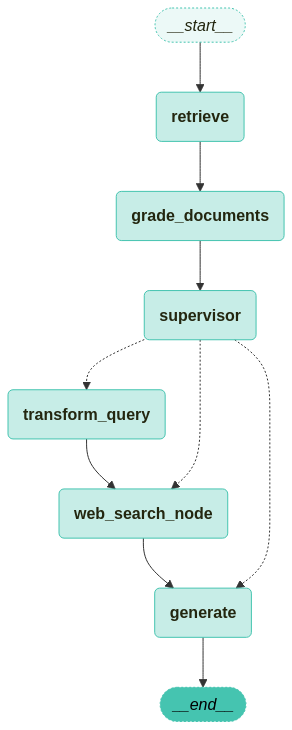

In [72]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)
